## Predictive modeling - Linear Regression model (Daily mean tempreture)

### **After removing outliers**

In [283]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
import statsmodels.formula.api as smf

In [284]:
kandy_weather = pd.read_csv('../data/processed/kandy_weather_no_outliers.csv', index_col=0, parse_dates=['time'])

In [285]:
#drop highly correlated columns 
kandy_weather = kandy_weather.drop(columns=['max_temperature', 'min_temperature', 'apparent_temperature_mean'])

In [286]:
kandy_weather

,weathercode,mean_temperature,shortwave_radiation,rainfall,max_wind_speed,max_wind_gust,dominant_Wind_Direction,evapotranspiration,rain_tomorrow,year,month,day
time,,,,,,,,,,,,
2010-01-01,2,22.0,18.09,0.0,15.3,38.9,57,3.43,0,2010,1,1
2010-01-02,2,22.2,15.47,0.0,13.3,33.1,46,2.95,1,2010,1,2
2010-01-03,51,22.1,14.99,0.1,10.7,28.1,40,2.84,1,2010,1,3
2010-01-04,51,21.9,16.55,0.6,10.4,29.2,23,3.16,0,2010,1,4
2010-01-08,51,22.5,12.02,0.8,9.4,23.0,326,2.33,1,2010,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-13,53,24.0,18.17,3.1,16.6,45.7,221,3.51,1,2023,6,13
2023-06-14,53,24.4,18.26,4.0,16.8,42.5,218,3.56,1,2023,6,14
2023-06-15,51,24.7,17.12,0.6,14.2,37.1,217,3.53,1,2023,6,15


In [287]:
print(kandy_weather.columns.tolist())


['weathercode', 'mean_temperature', 'shortwave_radiation', 'rainfall', 'max_wind_speed', 'max_wind_gust', 'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'year', 'month', 'day']


In [288]:
numerical_vars = ['shortwave_radiation', 'rainfall', 'max_wind_speed', 
                  'max_wind_gust', 'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'month']
categorical_vars = ['weathercode']
target = 'mean_temperature'

# Features and target (raw, do not dummy encode yet)
x = kandy_weather[categorical_vars + numerical_vars]
y = kandy_weather[target]

# Train/test split (chronological)
train_set = kandy_weather[kandy_weather['year'] <= 2018]
validation_set = kandy_weather[kandy_weather['year'] == 2019]
test_set = kandy_weather[kandy_weather['year'] >= 2020]

train_end = len(train_set)
val_end = train_end + len(validation_set)

x_train, y_train = x.iloc[:train_end], y.iloc[:train_end]
x_val, y_val = x.iloc[train_end:val_end], y.iloc[train_end:val_end]
x_test, y_test = x.iloc[val_end:], y.iloc[val_end:]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_vars),          # one-hot encode categorical
    ('num', StandardScaler(), numerical_vars)                        # scale numerical
])

pipeline = Pipeline([
    ('preprocessing', preprocessor),
    ('lr_model', LinearRegression())
])

pipeline.fit(x_train, y_train)


,steps,"[('preprocessing', ...), ('lr_model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...), ('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [289]:
# Get OneHotEncoder step inside ColumnTransformer
ohe = pipeline.named_steps['preprocessing'].named_transformers_['cat']

# Get feature names generated by OneHotEncoder
encoded_feature_names = ohe.get_feature_names_out(categorical_vars).tolist()

# Final full list of features (encoded categorical + numerical)
full_feature_names = encoded_feature_names + numerical_vars

In [290]:
# Get feature names after preprocessing
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out()

# Get coefficients and intercept
coefs = pipeline.named_steps['lr_model'].coef_
intercept = pipeline.named_steps['lr_model'].intercept_

# Combine into DataFrame
coef_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefs
})

print(f'intercept : {intercept}')

print(coef_df)


intercept : 22.69441165142247
                         Feature  Coefficient
0             cat__weathercode_1     0.281372
1             cat__weathercode_2     0.526274
2             cat__weathercode_3     0.690374
3            cat__weathercode_51     0.973525
4            cat__weathercode_53     1.139237
5            cat__weathercode_55     1.082869
6            cat__weathercode_61     1.068590
7            cat__weathercode_63     1.060213
8            cat__weathercode_65     0.449846
9       num__shortwave_radiation    -1.496991
10                 num__rainfall    -0.012755
11           num__max_wind_speed    -0.149241
12            num__max_wind_gust     0.125402
13  num__dominant_Wind_Direction     0.157204
14       num__evapotranspiration     2.087008
15            num__rain_tomorrow     0.091904
16                    num__month    -0.122140


In [291]:
def evaluate_model(model, X, y, dataset_name):
    """Evaluate model performance"""
    predictions = pipeline.predict(X)
    
    mse = mean_squared_error(y, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, predictions)
    r2 = r2_score(y, predictions)
    
    print(f"\n{dataset_name} Set Performance:")
    print(f"  RMSE: {rmse:.4f}°C")
    print(f"  MAE:  {mae:.4f}°C")
    print(f"  R²:   {r2:.4f}")
    
    return predictions, {'RMSE': rmse, 'MAE': mae, 'R2': r2}

# Evaluate on all sets
train_pred, train_metrics = evaluate_model(lr_model, x_train, y_train, "Training")
val_pred, val_metrics = evaluate_model(lr_model, x_val, y_val, "Validation")
test_pred, test_metrics = evaluate_model(lr_model, x_test, y_test, "Test")


Training Set Performance:
  RMSE: 0.4503°C
  MAE:  0.3523°C
  R²:   0.7330

Validation Set Performance:
  RMSE: 0.4483°C
  MAE:  0.3557°C
  R²:   0.7833

Test Set Performance:
  RMSE: 0.4623°C
  MAE:  0.3651°C
  R²:   0.7393


In [292]:
y_pred = pipeline.predict(x_test)

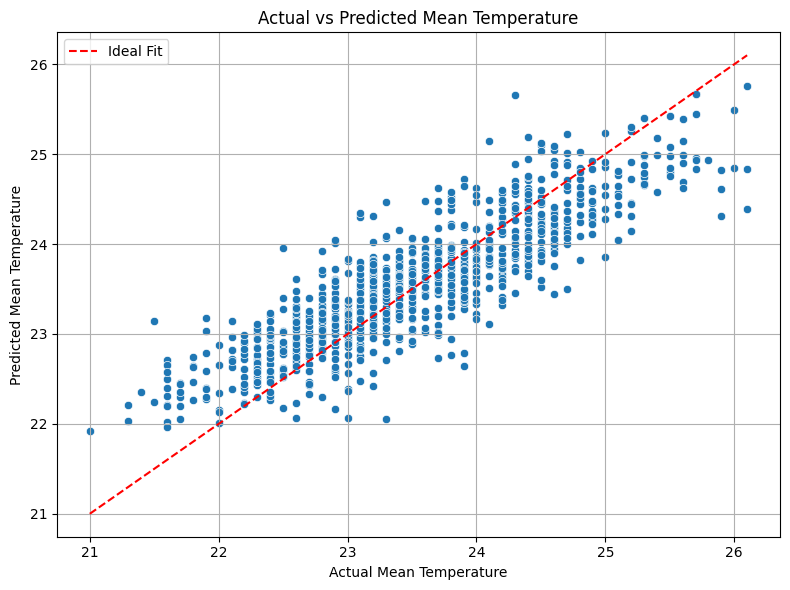

In [293]:
# Scatter plot: Actual vs Predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Ideal Fit')
plt.xlabel('Actual Mean Temperature')
plt.ylabel('Predicted Mean Temperature')
plt.title('Actual vs Predicted Mean Temperature')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [294]:
# --- Combine training data for statsmodels ---
train_data = x_train.copy()
train_data['mean_temperature'] = y_train

scaler = StandardScaler()
train_scaled = train_data.copy()
train_scaled[numerical_vars] = scaler.fit_transform(train_scaled[numerical_vars])

# --- Build the regression formula ---
formula = "mean_temperature ~ C(weathercode) + shortwave_radiation + rainfall + max_wind_speed + max_wind_gust + dominant_Wind_Direction + evapotranspiration + rain_tomorrow + month"

# --- Fit the OLS regression model ---
model = smf.ols(formula=formula, data=train_scaled).fit()

# --- Print full model summary ---
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:       mean_temperature   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     407.2
Date:                Thu, 18 Sep 2025   Prob (F-statistic):               0.00
Time:                        02:58:42   Log-Likelihood:                -1577.2
No. Observations:                2539   AIC:                             3190.
Df Residuals:                    2521   BIC:                             3295.
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                 

## Residuals Analysis

In [295]:
y_pred = pipeline.predict(x_test)
residuals = y_test - y_pred

In [296]:
# import numpy as np

# # Compute z-scores
# z_scores = (residuals - np.mean(residuals)) / np.std(residuals)

# # Find indices where |z| > 3
# outliers = np.where(np.abs(z_scores) > 3)
# print("Outlier indices:", outliers)


In [297]:
# # Keep only residuals with z-score <= 3
# residuals_clean = residuals[np.abs(z_scores) <= 3]

# print("Cleaned residuals:", residuals_clean)


In [298]:
# import pandas as pd

# residuals = pd.Series(residuals)  # if not already a Series

# residuals_clean = residuals[np.abs(z_scores) <= 3]


### Normality of errors

In [299]:
from statsmodels.stats.stattools import durbin_watson

dw_stat = durbin_watson(residuals)
print(f"Durbin–Watson Statistic: {dw_stat:.4f}")

Durbin–Watson Statistic: 0.6444


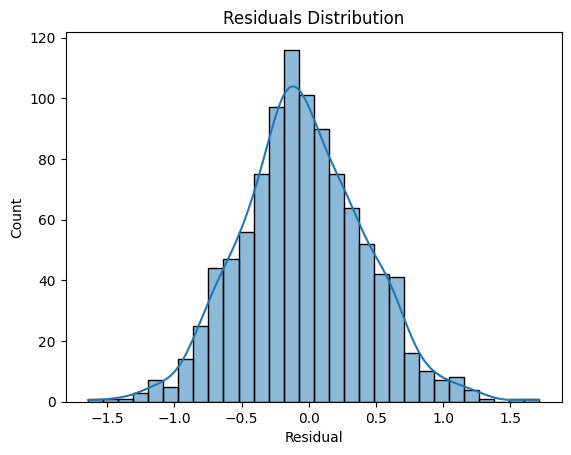

In [300]:
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals Distribution")
plt.xlabel("Residual")
plt.show()


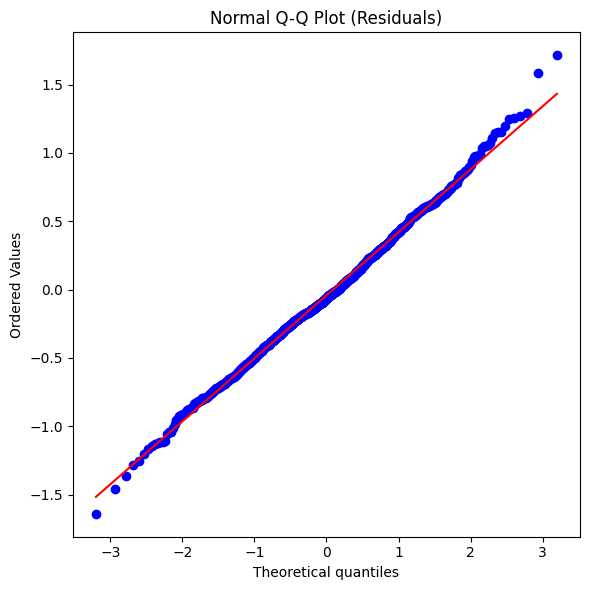

In [301]:
from scipy.stats import probplot

plt.figure(figsize=(6, 6))
probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot (Residuals)')
plt.tight_layout()
plt.show()

In [302]:
from scipy.stats import shapiro
stat, p = shapiro(residuals)
print("Shapiro-Wilk Test: stat=%.3f, p=%.3f" % (stat, p))

Shapiro-Wilk Test: stat=0.998, p=0.133


### Homoscedasticity

In [303]:
# # Keep mask of non-outliers
# mask = np.abs(z_scores) <= 3

# residuals_clean = residuals[mask]
# y_pred_clean = y_pred[mask]

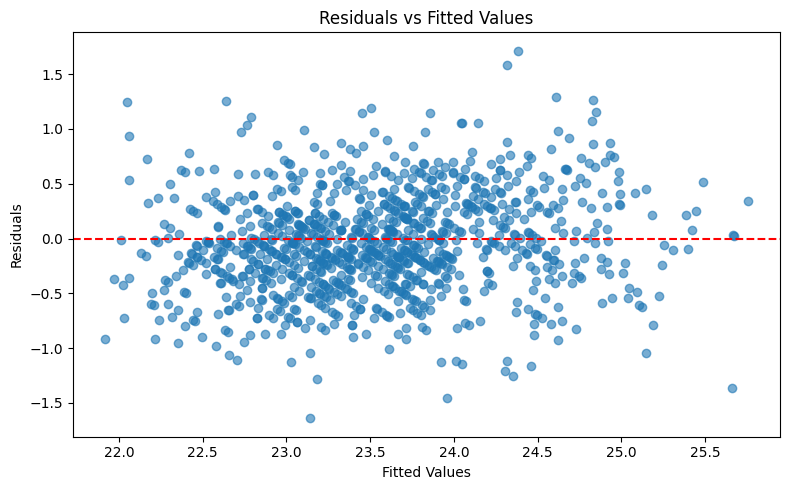

In [304]:

plt.figure(figsize=(8, 5))
plt.scatter(y_pred, residuals, alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.tight_layout()
plt.show()

Observations from your plot:

1.Centered around zero

    The residuals are scattered around the red line (y=0).

    This means your model is unbiased on average (no strong systematic under/over prediction). ✅

2.Spread of residuals

    The variance of residuals looks fairly constant across fitted values (between ~21 and 26).

    There is no strong funnel shape (e.g., narrow on one side, wide on the other).

    This suggests homoscedasticity (constant variance) is likely satisfied. ✅

3.No clear pattern

    Residuals don’t form curves or trends.

    If you saw a U-shape or wave-like structure, it would mean your linear model is missing some nonlinearity.

    Here, the scatter looks random → linearity assumption holds. ✅

4.Outliers

    A few points fall far below (e.g., residuals < -3).

    These are potential outliers that may influence the model. ⚠️

In [305]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Requires residuals & design matrix
import statsmodels.api as sm


# Compute z-scores for residuals
z_scores = (residuals - np.mean(residuals)) / np.std(residuals)
mask = np.abs(z_scores) <= 3   # True = keep

# Apply mask to residuals and x_test
residuals_clean = residuals[mask]
x_test_clean = x_test[mask]

# Add intercept to cleaned x_test
exog = sm.add_constant(x_test_clean)

# Run Breusch-Pagan test
bp_test = het_breuschpagan(residuals_clean, exog)

print("\n--- Breusch-Pagan Test ---")
print(f"Test Statistic: {bp_test[0]:.4f}")
print(f"p-value       : {bp_test[1]:.4f}")



--- Breusch-Pagan Test ---
Test Statistic: 77.4359
p-value       : 0.0000


### **Multicollinearity: VIF**

In [306]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# --- One-hot encode categorical variables ---
X = pd.get_dummies(
    train_data[['weathercode', 'shortwave_radiation', 'rainfall',
                'max_wind_speed', 'max_wind_gust',
                'dominant_Wind_Direction', 'evapotranspiration', 'rain_tomorrow', 'month']],
    drop_first=True
)

# --- Ensure numeric dtype (convert bool -> int, etc.) ---
X = X.astype(float)

# --- Drop rows with NaNs if any ---
X = X.dropna()

# --- Calculate VIF ---
vif = pd.DataFrame()
vif["Feature"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif)


                   Feature         VIF
0              weathercode    9.982176
1      shortwave_radiation  773.842454
2                 rainfall    3.373037
3           max_wind_speed   97.415294
4            max_wind_gust  135.549057
5  dominant_Wind_Direction    7.499148
6       evapotranspiration  706.866402
7            rain_tomorrow    7.285142
8                    month    5.376981
